In [1]:
import pandas as pd
import json
from geopy.distance import geodesic
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from scipy import stats

In [3]:
file_path_business = "/content/yelp_academic_dataset_business (2).csv"
file_path_category = "/content/yelp_academic_dataset_category (2).csv"
file_path_user = "/content/yelp_academic_dataset_user (2).csv"
# file_path_review = "/content/yelp_academic_dataset_review_notext (2).csv"
file_path_hotels = '/content/Google Hotels.csv'
file_path_rental = '/content/Google Hotels Rental API FL.xlsx'
df_business = pd.read_csv(file_path_business, on_bad_lines='skip')
df_category = pd.read_csv(file_path_category, on_bad_lines='skip')
df_user = pd.read_csv(file_path_user, on_bad_lines='skip')
# df_review = pd.read_csv(file_path_review, on_bad_lines='skip')
df_hotel = pd.read_csv(file_path_hotels)
df_rental = pd.read_excel(file_path_rental)

# Hotel Data

In [4]:
def expand_ratings(rating_str):
    try:
        # Convert the string to a list of dictionaries
        ratings = json.loads(rating_str.replace("'", '"'))
        # Create a dictionary with star ratings as keys and counts as values
        expanded = {f"star_{rating['stars']}": rating['count'] for rating in ratings}
        return expanded
    except Exception as e:
        print(f"Error processing row: {e}")
        return {}

# Apply the function to each row in the 'ratings' column
expanded_ratings = df_hotel['Ratings'].apply(expand_ratings)

# Convert the expanded ratings into separate columns and concatenate them back
expanded_df = pd.DataFrame(expanded_ratings.tolist())

# Concatenate the expanded DataFrame with the original DataFrame (if you want to keep original data)
df_hotel_expanded = pd.concat([df_hotel, expanded_df], axis=1)

In [5]:
df_hotel_expanded = df_hotel_expanded.rename(columns={
    'star_1': 'Star 1',
    'star_2': 'Star 2',
    'star_3': 'Star 3',
    'star_4': 'Star 4',
    'star_5': 'Star 5'
})
# df_hotel_expanded.head()

In [6]:
merged_df = pd.merge(df_business, df_category, on='business_id', how='inner')

# Now filter the merged DataFrame for Florida restaurants
florida_restaurants = merged_df[
    (merged_df['state'] == 'FL') &
    (merged_df['category_name'] == 'Restaurants')
]

In [7]:
# Define a function to extract zip code using regex
def extract_zipcode(address):
    # Regex pattern for U.S. zip code (5 digits)
    match = re.search(r'\b\d{5}\b', address)
    if match:
        return match.group(0)  # Return the matched zip code
    return None  # Return None if no match is found

# Apply the function to the 'address' column of the hotels DataFrame
df_hotel_expanded['zipcode'] = df_hotel_expanded['Address'].apply(extract_zipcode)

# Show the first few rows to verify
# df_hotel_expanded[['Address', 'zipcode']].head(20)

In [8]:
df_hotel_expanded.columns

Index(['Name', 'Description', 'Coordinates', 'Latitude', 'Longitude',
       'Hotel Class', 'Link', 'Ratings', 'Reviews', 'Reviews Breakdown',
       'Address', 'Star 5', 'Star 4', 'Star 3', 'Star 2', 'Star 1', 'zipcode'],
      dtype='object')

In [9]:
florida_restaurants['postal_code'] = florida_restaurants['postal_code'].astype(str)
df_hotel_expanded['zipcode'] = df_hotel_expanded['zipcode'].astype(str)
florida_restaurants.rename(columns={'name': 'restaurant name'}, inplace=True)
df_hotel_expanded.rename(columns={'Name': 'Hotel Name'}, inplace=True)

<ipython-input-9-c2ecb839d040>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida_restaurants['postal_code'] = florida_restaurants['postal_code'].astype(str)
<ipython-input-9-c2ecb839d040>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida_restaurants.rename(columns={'name': 'restaurant name'}, inplace=True)


In [10]:
florida_restaurants.count()

,0
bid,8731
business_id,8731
restaurant name,8731
address,8635
city,8731
state,8731
postal_code,8731
latitude,8731
longitude,8731
stars,8731


In [11]:
# Merge the two tables using zipcode
matched_zip_df = pd.merge(florida_restaurants, df_hotel_expanded, left_on='postal_code', right_on='zipcode', how='inner')

# Define a function to calculate the distance between two geographical points (latitude and longitude)
def calculate_distance(row):
    restaurant_coords = (row['latitude'], row['longitude'])
    hotel_coords = (row['Latitude'], row['Longitude'])
    return geodesic(restaurant_coords, hotel_coords).kilometers

# Apply the function to calculate distances for each pair of matching restaurants and hotels
matched_zip_df['distance_km'] = matched_zip_df.apply(calculate_distance, axis=1)

matched_zip_df[['restaurant name', 'Hotel Name', 'postal_code', 'distance_km', 'Star 1', 'Star 2', 'Star 3', 'Star 4', 'Star 5']].head()

,restaurant name,Hotel Name,postal_code,distance_km,Star 1,Star 2,Star 3,Star 4,Star 5
0,Vietnamese Food Truck,Aloft Tampa Downtown,33602,1.002244,133,77,145,375,787
1,Vietnamese Food Truck,"Hotel Flor Tampa Downtown, Tapestry Collection...",33602,0.421970,230,110,158,329,829
2,Vietnamese Food Truck,JW Marriott Tampa Water Street,33602,1.622866,53,14,28,117,873
3,Vietnamese Food Truck,"Le MÃ©ridien Tampa, The Courthouse",33602,0.590933,64,34,102,261,837
4,Vietnamese Food Truck,Tampa Marriott Water Street,33602,1.622182,172,105,289,1163,3770


In [12]:
matched_zip_df.columns

Index(['bid', 'business_id', 'restaurant name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'cid', 'category_name', 'Hotel Name', 'Description',
       'Coordinates', 'Latitude', 'Longitude', 'Hotel Class', 'Link',
       'Ratings', 'Reviews', 'Reviews Breakdown', 'Address', 'Star 5',
       'Star 4', 'Star 3', 'Star 2', 'Star 1', 'zipcode', 'distance_km'],
      dtype='object')

In [13]:
df_correlation = pd.DataFrame(columns=['distance_category', 'stars', 'average', 'thumbup'])

In [14]:
bins = [0, 1, 5, float('inf')]  # Bins: 0-1, 1-5, and greater than 5
labels = ['less than 1 km', '1-5 km', 'larger than 5 km']  # Labels for the bins
df_correlation['distance_category'] = pd.cut(matched_zip_df['distance_km'], bins=bins, labels=labels, right=False)

df_correlation['stars'] = matched_zip_df['stars']

df_correlation['average'] = ((matched_zip_df['Star 1'] + 2 * matched_zip_df['Star 2'] + 3 * matched_zip_df['Star 3']
                             + 4 * matched_zip_df['Star 4'] + 5 * matched_zip_df['Star 5'])
                             / (matched_zip_df['Star 1'] + matched_zip_df['Star 2'] + matched_zip_df['Star 3']
                             + matched_zip_df['Star 4'] + matched_zip_df['Star 5']))
df_correlation['thumbup'] = ((matched_zip_df['Star 4'] + matched_zip_df['Star 5'])
                             / (matched_zip_df['Star 1'] + matched_zip_df['Star 2'] + matched_zip_df['Star 3']
                             + matched_zip_df['Star 4'] + matched_zip_df['Star 5']))

In [15]:
df_correlation.head()

,distance_category,stars,average,thumbup
0,1-5 km,4.0,4.058668,0.765985
1,less than 1 km,4.0,3.855676,0.699275
2,1-5 km,4.0,4.606452,0.912442
3,less than 1 km,4.0,4.365948,0.845917
4,1-5 km,4.0,4.501000,0.897072


In [26]:
# Let's assume matched_zip_df['distance_km'] is a 2D distance matrix between restaurants and hotels:
restaurant_to_hotel_distances = matched_zip_df['distance_km'].values.reshape(len(matched_zip_df), -1)

# List to store the 5 closest hotels for each restaurant
closest_5_hotels = []

# Loop through each restaurant (row)
for i in range(len(restaurant_to_hotel_distances)):
    # Get all distances for restaurant i to hotels
    dist = restaurant_to_hotel_distances[i]

    # Find the indices of the 5 closest hotels
    closest_indices = np.argsort(dist)[:5]
    closest_5_hotels.append(closest_indices)  # Append the indices of the closest hotels

# Print the indices of the 5 closest hotels for each restaurant
for i, closest in enumerate(closest_5_hotels):
    print(f"Restaurant {i + 1}: Closest Hotels: {closest}")

流式输出内容被截断，只能显示最后 5000 行内容。
Restaurant 5543: Closest Hotels: [0]
Restaurant 5544: Closest Hotels: [0]
Restaurant 5545: Closest Hotels: [0]
Restaurant 5546: Closest Hotels: [0]
Restaurant 5547: Closest Hotels: [0]
Restaurant 5548: Closest Hotels: [0]
Restaurant 5549: Closest Hotels: [0]
Restaurant 5550: Closest Hotels: [0]
Restaurant 5551: Closest Hotels: [0]
Restaurant 5552: Closest Hotels: [0]
Restaurant 5553: Closest Hotels: [0]
Restaurant 5554: Closest Hotels: [0]
Restaurant 5555: Closest Hotels: [0]
Restaurant 5556: Closest Hotels: [0]
Restaurant 5557: Closest Hotels: [0]
Restaurant 5558: Closest Hotels: [0]
Restaurant 5559: Closest Hotels: [0]
Restaurant 5560: Closest Hotels: [0]
Restaurant 5561: Closest Hotels: [0]
Restaurant 5562: Closest Hotels: [0]
Restaurant 5563: Closest Hotels: [0]
Restaurant 5564: Closest Hotels: [0]
Restaurant 5565: Closest Hotels: [0]
Restaurant 5566: Closest Hotels: [0]
Restaurant 5567: Closest Hotels: [0]
Restaurant 5568: Closest Hotels: [0]
Restaurant 

In [16]:
model = smf.ols(formula='average ~ stars + C(distance_category)', data=df_correlation).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                average   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     36.82
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.16e-23
Time:                        18:56:59   Log-Likelihood:                -5261.3
No. Observations:               10542   AIC:                         1.053e+04
Df Residuals:                   10538   BIC:                         1.056e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    4.1120      0.020    206.795      0.000       4.073       4.151
C(distance_category)[T.1-5 km]               0.0031      0.009      0.353      0.724      -0.014       0.021
C(distance_category)[T.larger than 5 km]    -0.0967      0.013     -7.684      0.000      -0.121      -0.072
stars                                        0.0291      0.005      5.749      0.000       0.019       0.039
==============================================================================
Omnibus:                     3402.307   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11598.868
Skew:                          -1.629   Prob(JB):                         0.00
Kurtosis:                       6.974   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Short Term Rental Data

In [17]:
# Define a function to extract zip code using regex
def extract_zipcode_rental(address):
    # Regex pattern for U.S. zip code (5 digits)
    match = re.search(r'\b\d{5}\b', address)
    if match:
        return match.group(0)  # Return the matched zip code
    return None  # Return None if no match is found

# Apply the function to the 'address' column of the hotels DataFrame
df_rental['zipcode'] = df_rental['Address'].apply(extract_zipcode_rental)

# Show the first few rows to verify
df_rental.head(20)

,Name,Coordinates,Latitude,Longitude,Link,Ratings,Reviews,Address,zipcode
0,"""Riverbend Gem"" - Studio|Courtyard|TPA Heights","{'latitude': 28.001779556274414, 'longitude': ...",28.001780,-82.465950,https://www.staytealdoor.com/properties/6621a3...,3.3,3,"6002, North Dexter Avenue, Kenilworth Grove, T...",33604
1,Creek Cabin - Two-Bedroom House,"{'latitude': 28.21503257751465, 'longitude': -...",28.215033,-82.698647,https://www.google.com/travel/search?q=7008%2C...,3.6,7,"7008, Creek Drive, Pasco County, Florida, 3465...",34655
2,TownePlace Suites by Marriott Tampa North/I-75...,"{'latitude': 28.067001342773438, 'longitude': ...",28.067001,-82.371696,https://deals.vio.com?sig=73aca13c7f952d2641c1...,3.6,189,"6814, Woodstork Drive, Temple Terrace, Hillsbo...",33637
3,BayCation,"{'latitude': 28.048564910888672, 'longitude': ...",28.048565,-82.401100,https://www.vacasa.com/unit/118653,3.8,4,"5025, East 110th Avenue, Tampa, Hillsborough C...",33617
4,Sunny Studio,"{'latitude': 27.776987075805664, 'longitude': ...",27.776987,-82.690620,https://cohostalbookings.hospitable.rentals/pr...,3.8,8,"4216, 5th Avenue North, Central Oak Park, Sain...",33713
5,Tropical Vibe,"{'latitude': 28.02916145324707, 'longitude': -...",28.029161,-82.743187,https://www.vacasa.com/unit/107891,3.8,11,"2299, Colonial Drive, Pinellas County, Florida...",34698
6,300 ftÂ² Private room âˆ™ 1 bedroom âˆ™ 2 guests,"{'latitude': 28.266399383544922, 'longitude': ...",28.266399,-82.725151,https://www.google.com/travel/search?q=5400%2C...,4.0,1,"5400, Bellview Avenue, New Port Richey, Pasco ...",34652
7,448 Little Harbor,"{'latitude': 27.725954055786133, 'longitude': ...",27.725954,-82.473824,https://www.google.com/travel/search?q=448%2C%...,4.0,20,"448, Bahia Beach Boulevard, Hillsborough Count...",33570
8,Land's End 203 building 1 Cute Coastal and Com...,"{'latitude': 27.7414608001709, 'longitude': -8...",27.741461,-82.756218,https://www.google.com/travel/search?q=7553%2C...,4.0,48,"7553, Bayshore Drive, Sunset Beach, Treasure I...",33706
9,"Villa KailÄsa - Pool, 6min drive to the Beach","{'latitude': 27.823320388793945, 'longitude': ...",27.823320,-82.778641,https://www.google.com/travel/search?q=5636%2C...,4.0,7,"5636, 100th Way North, Seminole, Pinellas Coun...",33708


In [18]:
df_rental.rename(columns={'Ratings': 'rental_ratings'}, inplace=True)
df_rental.rename(columns={'Name': 'Rental Name'}, inplace=True)

df_rental.head()

,Rental Name,Coordinates,Latitude,Longitude,Link,rental_ratings,Reviews,Address,zipcode
0,"""Riverbend Gem"" - Studio|Courtyard|TPA Heights","{'latitude': 28.001779556274414, 'longitude': ...",28.001780,-82.465950,https://www.staytealdoor.com/properties/6621a3...,3.3,3,"6002, North Dexter Avenue, Kenilworth Grove, T...",33604
1,Creek Cabin - Two-Bedroom House,"{'latitude': 28.21503257751465, 'longitude': -...",28.215033,-82.698647,https://www.google.com/travel/search?q=7008%2C...,3.6,7,"7008, Creek Drive, Pasco County, Florida, 3465...",34655
2,TownePlace Suites by Marriott Tampa North/I-75...,"{'latitude': 28.067001342773438, 'longitude': ...",28.067001,-82.371696,https://deals.vio.com?sig=73aca13c7f952d2641c1...,3.6,189,"6814, Woodstork Drive, Temple Terrace, Hillsbo...",33637
3,BayCation,"{'latitude': 28.048564910888672, 'longitude': ...",28.048565,-82.401100,https://www.vacasa.com/unit/118653,3.8,4,"5025, East 110th Avenue, Tampa, Hillsborough C...",33617
4,Sunny Studio,"{'latitude': 27.776987075805664, 'longitude': ...",27.776987,-82.690620,https://cohostalbookings.hospitable.rentals/pr...,3.8,8,"4216, 5th Avenue North, Central Oak Park, Sain...",33713


In [19]:
# Merge the two tables using zipcode
matched_rental_df = pd.merge(florida_restaurants, df_rental, left_on='postal_code', right_on='zipcode', how='inner')

# Define a function to calculate the distance between two geographical points (latitude and longitude)
def calculate_distance(row):
    restaurant_coords = (row['latitude'], row['longitude'])
    rental_coords = (row['Latitude'], row['Longitude'])
    return geodesic(restaurant_coords, rental_coords).kilometers

# Apply the function to calculate distances for each pair of matching restaurants and hotels
matched_rental_df['distance_km'] = matched_rental_df.apply(calculate_distance, axis=1)

matched_rental_df[['restaurant name', 'Rental Name', 'postal_code', 'distance_km', 'stars', 'rental_ratings']].head()

,restaurant name,Rental Name,postal_code,distance_km,stars,rental_ratings
0,The Pearl,Land's End 203 building 1 Cute Coastal and Com...,33706,3.283853,4.0,4.0
1,The Pearl,Sunrise Resort Unit 502,33706,4.620419,4.0,4.7
2,Trust Me BBQ,Discover Your Home Away from Home in Riverview,33569,0.875711,4.0,5.0
3,Trust Me BBQ,"Entire home just outside Tampa, FL",33569,2.269097,4.0,5.0
4,PDQ Temple Terrace,BayCation,33617,0.717325,3.0,3.8


In [24]:
matched_rental_df.to_csv('matched_rental_df.csv', index=False)

In [20]:
df_rental.head()

,Rental Name,Coordinates,Latitude,Longitude,Link,rental_ratings,Reviews,Address,zipcode
0,"""Riverbend Gem"" - Studio|Courtyard|TPA Heights","{'latitude': 28.001779556274414, 'longitude': ...",28.001780,-82.465950,https://www.staytealdoor.com/properties/6621a3...,3.3,3,"6002, North Dexter Avenue, Kenilworth Grove, T...",33604
1,Creek Cabin - Two-Bedroom House,"{'latitude': 28.21503257751465, 'longitude': -...",28.215033,-82.698647,https://www.google.com/travel/search?q=7008%2C...,3.6,7,"7008, Creek Drive, Pasco County, Florida, 3465...",34655
2,TownePlace Suites by Marriott Tampa North/I-75...,"{'latitude': 28.067001342773438, 'longitude': ...",28.067001,-82.371696,https://deals.vio.com?sig=73aca13c7f952d2641c1...,3.6,189,"6814, Woodstork Drive, Temple Terrace, Hillsbo...",33637
3,BayCation,"{'latitude': 28.048564910888672, 'longitude': ...",28.048565,-82.401100,https://www.vacasa.com/unit/118653,3.8,4,"5025, East 110th Avenue, Tampa, Hillsborough C...",33617
4,Sunny Studio,"{'latitude': 27.776987075805664, 'longitude': ...",27.776987,-82.690620,https://cohostalbookings.hospitable.rentals/pr...,3.8,8,"4216, 5th Avenue North, Central Oak Park, Sain...",33713


In [21]:
df_correlation_rental = pd.DataFrame(columns=['distance_category', 'stars', 'rental_ratings'])

bins = [0, 1, 5, float('inf')]  # Bins: 0-1, 1-5, and greater than 5
labels = ['less than 1 km', '1-5 km', 'larger than 5 km']  # Labels for the bins
df_correlation_rental['distance_category'] = pd.cut(matched_rental_df['distance_km'], bins=bins, labels=labels, right=False)

df_correlation_rental['stars'] = matched_rental_df['stars']
df_correlation_rental['rental_ratings'] = matched_rental_df['rental_ratings']
df_correlation_rental

,distance_category,stars,rental_ratings
0,1-5 km,4.0,4.0
1,1-5 km,4.0,4.7
2,less than 1 km,4.0,5.0
3,1-5 km,4.0,5.0
4,less than 1 km,3.0,3.8
...,...,...,...
11501,1-5 km,3.5,4.0
11502,less than 1 km,3.5,5.0
11503,1-5 km,3.5,5.0
11504,1-5 km,3.5,5.0


In [22]:
model = smf.ols(formula='rental_ratings ~ stars + C(distance_category)', data=df_correlation_rental).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rental_ratings   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     20.96
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           1.56e-13
Time:                        18:57:21   Log-Likelihood:                -4862.5
No. Observations:               11506   AIC:                             9733.
Df Residuals:                   11502   BIC:                             9762.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    4.7340      0.018    262.137      0.000       4.699       4.769
C(distance_category)[T.1-5 km]               0.0266      0.010      2.672      0.008       0.007       0.046
C(distance_category)[T.larger than 5 km]     0.0742      0.014      5.398      0.000       0.047       0.101
stars                                       -0.0231      0.004     -5.431      0.000      -0.031      -0.015
==============================================================================
Omnibus:                     2705.688   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5351.489
Skew:                          -1.429   Prob(JB):                         0.00
Kurtosis:                       4.729   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# API Price Level

In [ ]:
# Link for API to extract price level:
# https://colab.research.google.com/drive/1E8gfRpXtURdHon4BbXBy9budVkToFKBL?usp=sharing#scrollTo=7WVRdaOCqHva

In [ ]:
df_pricelevel = pd.read_excel('/content/pricelevels_final.xlsx')

In [ ]:
df_pricelevel.head()

,name,price
0,Vietnamese Food Truck,NaN
1,Cesarina's Italian Deli,$
2,Roman Forum,NaN
3,Pizza Joe's - a Taste of Buffalo,NaN
4,Top Shelf Sports Lounge,$$


In [ ]:
florida_restaurants.head()

,bid,business_id,restaurant name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,cid,category_name
56,12,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.95527,-82.45632,4.0,10,0,57,Restaurants
70,15,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.91612,-82.76046,4.5,100,0,71,Restaurants
275,59,uI9XODGY_2_ieTE6xJ0myw,Roman Forum,10440 N Dale Mabry Hwy,Tampa,FL,33618,28.04620,-82.50505,4.0,23,0,276,Restaurants
278,60,JgpnXv_0XhV3SfbfB50nxw,Joe's Pizza,2038 N Dale Mabry Hwy,Tampa,FL,33607,27.96051,-82.50613,4.0,35,0,279,Restaurants
360,80,pJfh3Ct8iL58NZa8ta-a5w,Top Shelf Sports Lounge,3173 Cypress Ridge Blvd,Wesley Chapel,FL,33544,28.19625,-82.38062,4.5,95,0,361,Restaurants


In [ ]:
merged_florida_restaurants = pd.merge(florida_restaurants, df_pricelevel,
                                      left_on='restaurant name',
                                      right_on='name',
                                      how='left',
                                      suffixes=('_df1', '_df2'))
merged_florida_restaurants

,bid,business_id,restaurant name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,cid,category_name,name,price
0,12,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.95527,-82.45632,4.0,10,0,57,Restaurants,Vietnamese Food Truck,NaN
1,15,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.91612,-82.76046,4.5,100,0,71,Restaurants,NaN,NaN
2,59,uI9XODGY_2_ieTE6xJ0myw,Roman Forum,10440 N Dale Mabry Hwy,Tampa,FL,33618,28.04620,-82.50505,4.0,23,0,276,Restaurants,Roman Forum,NaN
3,60,JgpnXv_0XhV3SfbfB50nxw,Joe's Pizza,2038 N Dale Mabry Hwy,Tampa,FL,33607,27.96051,-82.50613,4.0,35,0,279,Restaurants,NaN,NaN
4,80,pJfh3Ct8iL58NZa8ta-a5w,Top Shelf Sports Lounge,3173 Cypress Ridge Blvd,Wesley Chapel,FL,33544,28.19625,-82.38062,4.5,95,0,361,Restaurants,Top Shelf Sports Lounge,$$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76633,150250,8MzF1Tlgz0pOkxmhP5dYzA,El Cap Restaurant,3500 4th St N,St. Petersburg,FL,33704,27.80414,-82.63885,3.5,414,0,668163,Restaurants,El Cap Restaurant,$
76634,150263,-bZQH8yjm7ntTyGeLQwh8Q,Farmer's Kitchen Restaurant,3500 E Bay Dr,Largo,FL,33771,27.91679,-82.75039,4.0,6,0,668223,Restaurants,NaN,NaN
76635,150272,BIyT7Kr7tMJqlfp4oOOYQg,Copper Bell Cafe,11228 Boyette Rd,Riverview,FL,33569,27.85374,-82.31689,3.5,49,0,668269,Restaurants,NaN,NaN
76636,150293,esBGrrmuZzSiECyRBoKvvA,Colony Grill - St. Petersburg,670 Central Ave,St. Petersburg,FL,33701,27.77087,-82.64307,4.5,38,0,668358,Restaurants,Colony Grill - St. Petersburg,$$


In [ ]:
print(florida_restaurants['business_id'].duplicated().sum())

0


In [ ]:
print(merged_florida_restaurants['business_id'].duplicated().sum())

67907


In [ ]:
merged_florida_restaurants = merged_florida_restaurants.drop_duplicates(subset='business_id')

In [ ]:
merged_florida_restaurants.count()

,0
bid,8731
business_id,8731
restaurant name,8731
address,8635
city,8731
state,8731
postal_code,8731
latitude,8731
longitude,8731
stars,8731


In [ ]:
# Categorize restaurants into low-priced and high-priced
def categorize_price(price_category):
    if price_category in ['$','$$']:
        return 'low-priced'
    elif price_category in ['$$$', '$$$$']:
        return 'high-priced'
    else:
        return np.nan

# Apply categorization
merged_florida_restaurants['price_range_category'] = merged_florida_restaurants['price_category'].apply(categorize_price)

# Display the first few rows to check
print(merged_florida_restaurants[['restaurant name', 'price_category', 'price_range_category']].head(10))

                restaurant name price_category price_range_category
0         Vietnamese Food Truck            NaN                  NaN
1          Zio's Italian Market            NaN                  NaN
2                   Roman Forum            NaN                  NaN
3                   Joe's Pizza            NaN                  NaN
4       Top Shelf Sports Lounge             $$           low-priced
6                       Impasto            NaN                  NaN
7                     The Pearl            $$$          high-priced
8        Chipotle Mexican Grill              $           low-priced
37                 Trust Me BBQ            NaN                  NaN
38  Kinjo's Japanese Restaurant            NaN                  NaN


<ipython-input-72-cee696960d4d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_florida_restaurants['price_range_category'] = merged_florida_restaurants['price_category'].apply(categorize_price)


In [ ]:
# Extract ratings for low-priced and high-priced restaurants
low_price_ratings = merged_florida_restaurants[merged_florida_restaurants['price_range_category'] == 'low-priced']['stars']
high_price_ratings = merged_florida_restaurants[merged_florida_restaurants['price_range_category'] == 'high-priced']['stars']

# Perform a t-test to compare the means of ratings for low-priced and high-priced restaurants
t_stat, p_value = stats.ttest_ind(low_price_ratings.dropna(), high_price_ratings.dropna())

# Display the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -5.470023063797485, P-value: 4.747740691888628e-08


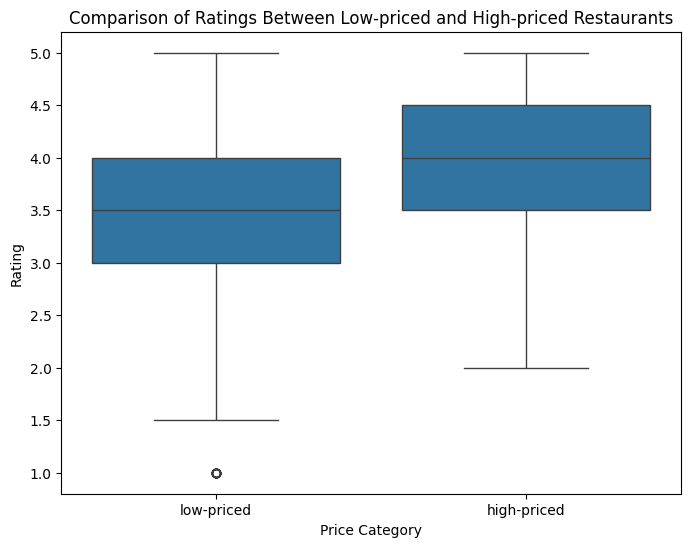

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to compare ratings between price categories
plt.figure(figsize=(8,6))
sns.boxplot(x='price_range_category', y='stars', data=merged_florida_restaurants)
plt.title('Comparison of Ratings Between Low-priced and High-priced Restaurants')
plt.xlabel('Price Category')
plt.ylabel('Rating')
plt.show()

In [ ]:
# 还没检查过！！！！！！！

# Step 1: Merge the DataFrames on 'restaurant_name'
merged_df = pd.merge(df1, df2, on='restaurant_name', how='inner')

# Step 2: Convert 'price_level' to a categorical variable
merged_df['price_level'] = merged_df['price_level'].astype('category')

# Step 3: Run the OLS regression
model = smf.ols(formula='stars ~ C(price_level) + distance', data=merged_df).fit()

# Step 4: Display the results
print(model.summary())

In [ ]:
# # price加入control variable
# star ~ distance + price_level
# 离家最近的五家餐厅。